# Vanishing Gradients and Exploding Gradients in RNNs : Ungraded Lecture Notebook
In this notebook, you'll take another look at vanishing and exploding gradients in RNNs, from an intuitive standpoint.

## Background
Vanilla RNNs are prone to vanishing and exploding gradients when dealing with long sequences. Recall that the gradient with respect to $W_h$ is proportional to a sum of products:

$$\frac{\delta L}{\delta W_h} \propto \sum_{1\le k\le t} \left(\prod_{t\ge i>k} \frac{\delta h_i}{\delta h_{i-1}}\right)\frac{\delta h_k}{\delta W_h}$$

where, for step $k$ far away from the place where the loss is computed ($t$), the product

$$\prod_{t\ge i>k} \frac{\delta h_i}{\delta h_{i-1}}$$

can either go to 0 or infinity depending on the values of the partial derivative of the hidden state $\frac{\delta h_i}{\delta h_{i-1}}$. In this ungraded lab, you will take a closer look at the partial derivative of the hidden state, and I'll show you how gradient problems arise when dealing with long sequences in vanilla RNNs. 

## Imports

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

%matplotlib inline

## Activations & Partial Derivative

### Partial Derivative
Recall that the hidden state at step $i$ is defined as:

$$h_i= \sigma(W_{hh} h_{i-1} + W_{hx} x_i + b_h)$$

where $\sigma$ is an activation function (usually sigmoid). So, you can use the chain rule to get the partial derivative:

$$\frac{\delta h_i}{\delta h_{i-1}} = W_{hh}^T \text{diag} (\sigma'(W_{hh} h_{i-1} + W_{hx} x_i + b_h))$$

$W_h^T$ is the transpose of the weight matrix, and $\sigma'$ is the gradient of the activation function. The gradient of the activation function is a vector of size equal to the hidden state size, and the $\text{diag}$ converts that vector into a diagonal matrix. You <strong>don't have to worry about the calculus</strong> behind this derivative, and you only need to be familiar with the form it takes.  

### Vanishing and Exploding Gradient Conditions

When the product 

$$\prod_{t\ge i > k} \frac{\partial h_i}{\partial h_{i-1}} = \prod_{t\ge i > k} W_{hh}^T \text{diag} (\sigma'(W_{hh} h_{i-1} + W_{hx} x_i + b_h))$$

approaches 0, you face vanishing gradient problems where the contribution of item $k$ in the sequence is neglected. Conversely, when the product approaches infinity you will face exploding gradients and convergence problems arise. For that product approaching either of those values, two conditions need to be met:

<ol>
<li> Derivative of the activation function is bounded by some value $\alpha$ </li>
<li> The absolute value of the largest eigenvalue of the weight matrix $W_{hh}$ is lower than $\frac{1}{\alpha}$ (sufficient condition for vanishing gradient), or greater than $\frac{1}{\alpha}$ (necessary condition for exploding gradient).</li> 
</ol>

### Activation

So let's check the first condition for the sigmoid function. Run the cell below to get an interactive plot of the sigmoid function and its derivative at different points. Feel free to change the argument values to check if the derivative is bounded or not.

In [64]:
# Data

### START CODE HERE ###
x = np.linspace(-6, 6, 100)  # try changing the range of values in the data. eg: (-100,100,1000)
### END CODE HERE ###
# Activation
# Interval [0, 1]
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

activations = sigmoid(x)

# Gradient
# Interval [0, 0.25]
def sigmoid_gradient(x):
    return sigmoid(x) * (1 - sigmoid(x))

# Add the tangent line
def plot_func(x_tan = 0):
    plt.plot(x, activations)
    plt.title("Sigmoid Function and Gradient")
    plt.xlabel("$x$")
    plt.ylabel("sigmoid($x$)")
    plt.text(x_tan, sigmoid(x_tan), f"Gradient: {sigmoid_gradient(x_tan):.4f}")
    plt.xlim((-6,6))
    plt.ylim((-0.5,1.5))
    plt.rcParams['figure.figsize'] = [7, 5]
    y_tan = sigmoid(x_tan)  # y value
    span = 4 # line span along x axis
    data_tan = np.linspace(x_tan - span, x_tan + span)  # x values to plot
    gradient_tan = sigmoid_gradient(x_tan)     # gradient of the tangent
    tan = y_tan + gradient_tan * (data_tan - x_tan)     # y values to plot
    plt.plot(x_tan, y_tan, marker="o", color="orange", label=True)  # marker
    plt.plot(data_tan, tan, linestyle="--", color="orange")         # line
    plt.show()

interact(plot_func, x_tan = widgets.FloatSlider(value=0,
                                            min=-6,
                                            max=6,
                                            step=0.5))

interactive(children=(FloatSlider(value=0.0, description='x_tan', max=6.0, min=-6.0, step=0.5), Output()), _do…

<function __main__.plot_func(x_tan=0)>

As you checked, the derivative of the sigmoid function is bounded by $\alpha=\frac{1}{4}$. So vanishing gradient problems will arise for long-term components if the largest eigenvalue of $W_{hh}$ is lower than 4, and exploding gradient problems will happen if the largest eigenvalue is larger than 4. 

## Vanishing Gradient with Sigmoid Activation 

Let's generate a random checkpoint for an RNN model and assume that the sequences are of length $t=20$:

In [96]:
np.random.seed(12345)
t = 20
h = np.random.randn(5,t)
x = np.random.randn(5,t)

In [98]:
b_h = np.random.randn(5,1)
W_hx = np.random.randn(5,5)

In the next cell, you will create a random matrix $W_{hh}$ with eigenvalues lower than four.

In [99]:
eig = np.random.rand(5)*4 #Random eigenvalues lower than 4
Q = np.random.randn(5,5) #Random eigenvectors stacked in matrix Q
W_hh = Q@np.diag(eig)@np.linalg.inv(Q) #W_hh

In [100]:
np.random.seed(3)
np.random.standard_normal((5,5))

array([[ 1.78862847,  0.43650985,  0.09649747, -1.8634927 , -0.2773882 ],
       [-0.35475898, -0.08274148, -0.62700068, -0.04381817, -0.47721803],
       [-1.31386475,  0.88462238,  0.88131804,  1.70957306,  0.05003364],
       [-0.40467741, -0.54535995, -1.54647732,  0.98236743, -1.10106763],
       [-1.18504653, -0.2056499 ,  1.48614836,  0.23671627, -1.02378514]])

Finally, let us define the product function for a determined step $k$.

In [101]:
def prod(k):
    p = 1 
    for i in range(t-1, k-2, -1):
        p *= W_hh.T@np.diag(sigmoid_gradient(W_hh@h[:,i]+ W_hx@x[:,i] + b_h))
    return p

Now, you can plot the contribution to the gradient for different steps $k$.

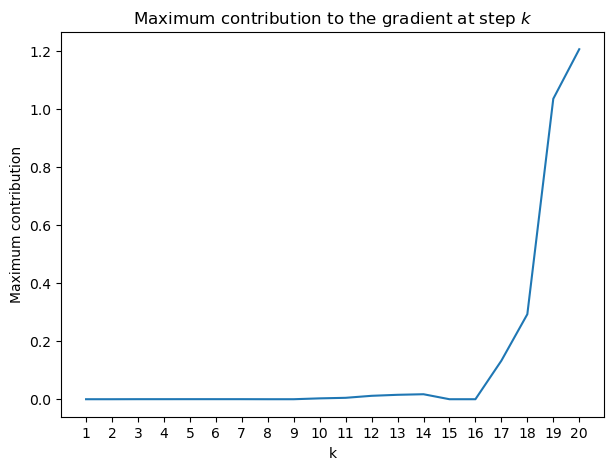

In [102]:
product = np.zeros(20)
for k in range(t):
    product[k] = np.max(prod(k+1))

plt.plot(np.array(range(t))+1, product)
plt.title("Maximum contribution to the gradient at step $k$");
plt.xlabel("k");
plt.ylabel("Maximum contribution");
plt.xticks(np.array(range(t))+1);

With the largest eigenvalue of the weight matrix $W_{hh}$ being lower than 4 --with a sigmoid activation function, the contribution of the early items in the sequence to the gradient go to zero. In practice, this will make your RNN rely only upon the most recent items in the series. 

## Exploding Gradient with Sigmoid Activation 

An essential difference with the vanishing gradient problem is that the condition for exploding gradients is necessary but not sufficient. Therefore, it is very likely that you will face vanishing gradients rather than exploding gradient problems. However, let's fabricate an example for exploding gradients.

In [93]:
np.random.seed(12345)
t = 20
h = np.zeros((5,t))
x = np.zeros((5,t))

In [94]:
b_h = np.zeros((5,1))
W_hx = np.random.randn(5,5)

In the next cell, a random matrix $W_{hh}$ with eigenvalues greater than 4 is created

In [10]:
eig = 4 + np.random.rand(5)*10 #Random eigenvalues greater than 4
Q = np.random.randn(5,5) #Random eigenvectors stacked in matrix Q
W_hh = Q@np.diag(eig)@np.linalg.inv(Q) #W_hh

Now, you can plot the contribution to the gradient for different steps $k$.

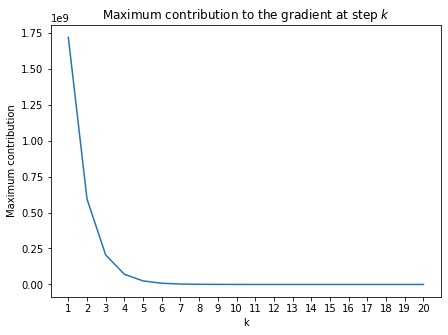

In [11]:
product = np.zeros(20)
for k in range(t):
    product[k] = np.max(prod(k+1))

plt.plot(np.array(range(t))+1, product)
plt.title("Maximum contribution to the gradient at step $k$");
plt.xlabel("k");
plt.ylabel("Maximum contribution");
plt.xticks(np.array(range(t))+1);

With the largest eigenvalue of the weight matrix $W_{hh}$ being greater than 4 --with a sigmoid activation function, the contribution of the early items in the sequence to the gradient goes to infinity. In practice, this will make you face convergence problems during training.

Now you are more familiar with the conditions for vanishing and exploding gradient problems. You should take away that for vanishing gradient it is <strong>sufficient</strong> to satisfy an eigenvalue condition, while for the exploding gradient problem it is <strong>neccesary</strong> but not enough. I used the weight matrix $W_{hh}$ in this discussion, but everything exposed here also applies for $W_{hx}$.

## Solution
One solution is to use RNN architectures specially designed to avoid these problems (like GRUs and LSTMs). Other solutions involve skip-connections or gradient clipping. But those are both discussions for another time.